In [1]:
!pip install vega_datasets
!pip install -U altair
!pip install -U jupyter notebook
!pip install -U vega
!jupyter nbextension install --sys-prefix --py vega
!jupyter nbextension enable vega --py --sys-prefix

     |████████████████████████████████| 210 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 727 kB 2.7 MB/s eta 0:00:01
  Attempting uninstall: altair
    Found existing installation: altair 4.0.1
    Uninstalling altair-4.0.1:
      Successfully uninstalled altair-4.0.1
Requirement already up-to-date: jupyter in /opt/conda/lib/python3.6/site-packages (1.0.0)
     |████████████████████████████████| 9.7 MB 2.8 MB/s eta 0:00:01


  Attempting uninstall: notebook
    Found existing installation: notebook 5.5.0
    Uninstalling notebook-5.5.0:
      Successfully uninstalled notebook-5.5.0
     |████████████████████████████████| 1.2 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 10.0 MB 53.2 MB/s eta 0:00:01


ERROR: pandas-profiling 2.5.0 has requirement pandas==0.25.3, but you'll have pandas 1.0.3 which is incompatible.
ERROR: hypertools 0.6.2 has requirement scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3
Installing /opt/conda/lib/python3.6/site-packages/vega/static -> jupyter-vega
Making directory: /opt/conda/share/jupyter/nbextensions/jupyter-vega/
Copying: /opt/conda/lib/python3.6/site-packages/vega/static/widget.js -> /opt/conda/share/jupyter/nbextensions/jupyter-vega/widget.js
Copying: /opt/conda/lib/python3.6/site-packages/vega/static/vega.js -> /opt/conda/share/jupyter/nbextensions/jupyter-vega/vega.js
Copying: /opt/conda/lib/python3.6/site-packages/vega/static/widget.js.map -> /opt/conda/share/jupyter/nbextensions/jupyter-vega/widget.js.map
Copying: /opt/conda/lib/python3.6/site-packa

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
# import plotly.express as px
import seaborn as sns
import numpy as np
import re

# alt.data_transformers.enable('default', max_rows=10_000_000)
alt.data_transformers.enable('json')
alt.renderers.enable('notebook')

DataTransformerRegistry.enable('default')

In [4]:
isocodes = pd.read_csv('../input/countries-iso-codes/wikipedia-iso-country-codes.csv')
isocodes.columns = isocodes.columns.str.replace(' ', '_').str.lower()
isocodes = isocodes.rename({"english_short_name_lower_case": 'country_name'}, axis=1)
isocodes

country_name alpha-2_code alpha-3_code  numeric_code     iso_3166-2
0          Afghanistan           AF          AFG             4  ISO 3166-2:AF
1        Åland Islands           AX          ALA           248  ISO 3166-2:AX
2              Albania           AL          ALB             8  ISO 3166-2:AL
3              Algeria           DZ          DZA            12  ISO 3166-2:DZ
4       American Samoa           AS          ASM            16  ISO 3166-2:AS
..                 ...          ...          ...           ...            ...
241  Wallis and Futuna           WF          WLF           876  ISO 3166-2:WF
242     Western Sahara           EH          ESH           732  ISO 3166-2:EH
243              Yemen           YE          YEM           887  ISO 3166-2:YE
244             Zambia           ZM          ZMB           894  ISO 3166-2:ZM
245           Zimbabwe           ZW          ZWE           716  ISO 3166-2:ZW

[246 rows x 5 columns]

In [5]:
ecdc = (pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
        .assign(date=lambda f: f['date'].pipe(pd.to_datetime))
       )

ecdc.head()

iso_code location       date  total_cases  new_cases  total_deaths  \
0      ABW    Aruba 2020-03-13            2          2             0   
1      ABW    Aruba 2020-03-20            4          2             0   
2      ABW    Aruba 2020-03-24           12          8             0   
3      ABW    Aruba 2020-03-25           17          5             0   
4      ABW    Aruba 2020-03-26           19          2             0   

   new_deaths  total_cases_per_million  new_cases_per_million  \
0           0                   18.733                 18.733   
1           0                   37.465                 18.733   
2           0                  112.395                 74.930   
3           0                  159.227                 46.831   
4           0                  177.959                 18.733   

   total_deaths_per_million  new_deaths_per_million  total_tests  new_tests  \
0                       0.0                     0.0          NaN        NaN   
1                       0.0                     0.0          NaN        NaN   
2                       0.0                     0.0          NaN        NaN   
3                       0.0                     0.0          NaN        NaN   
4                       0.0                     0.0          NaN        NaN   

   total_tests_per_thousand  new_tests_per_thousand tests_units  
0                       NaN                     NaN         NaN  
1                       NaN                     NaN         NaN  
2                       NaN                     NaN         NaN  
3                       NaN                     NaN         NaN  
4                       NaN                     NaN         NaN

In [6]:
from io import StringIO
import requests

url = 'https://covid19-static.cdn-apple.com/covid19-mobility-data/2006HotfixDev13/v1/en-us/applemobilitytrends-2020-04-22.csv'
response = requests.get(url)
apple_mobility = pd.read_csv(StringIO(response.content.decode())).set_index(['geo_type', 'region', 'transportation_type']).rename_axis("date", axis=1).stack().rename('change')

location_code = ecdc.groupby(['location', 'iso_code']).first().iloc[:, 0].reset_index().iloc[:,:2]
apple_mobility = (apple_mobility
                  .reset_index()
                  .replace({'UK': 'United Kingdom', 'Republic of Korea': 'South Korea'})  # Only missing is Macao
                  .merge(location_code, left_on='region', right_on='location', how='left'))
apple_mobility

geo_type   region transportation_type        date  change  \
0      country/region  Albania             driving  2020-01-13  100.00   
1      country/region  Albania             driving  2020-01-14   95.30   
2      country/region  Albania             driving  2020-01-15  101.43   
3      country/region  Albania             driving  2020-01-16   97.20   
4      country/region  Albania             driving  2020-01-17  103.55   
...               ...      ...                 ...         ...     ...   
39890            city   Zurich             walking  2020-04-18   76.06   
39891            city   Zurich             walking  2020-04-19   74.22   
39892            city   Zurich             walking  2020-04-20   65.06   
39893            city   Zurich             walking  2020-04-21   66.18   
39894            city   Zurich             walking  2020-04-22   72.35   

      location iso_code  
0      Albania      ALB  
1      Albania      ALB  
2      Albania      ALB  
3      Albania      ALB  
4      Albania      ALB  
...        ...      ...  
39890      NaN      NaN  
39891      NaN      NaN  
39892      NaN      NaN  
39893      NaN      NaN  
39894      NaN      NaN  

[39895 rows x 7 columns]

In [7]:
mobility = (pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")
            .assign(date=lambda f: f['date'].pipe(pd.to_datetime))
           )

def safe_match(pat, text):
    match = re.match(pat, text)
    return match.groups()[0] if match else text

mobility.columns = mobility.columns.map(lambda col: safe_match("(.*)_percent", col))
mobility = (mobility
            .merge(isocodes, left_on='country_region_code', right_on='alpha-2_code', how='left')
            .merge(location_code, left_on='alpha-3_code', right_on='iso_code', how='left'))
mobility

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


country_region_code        country_region sub_region_1 sub_region_2  \
0                       AE  United Arab Emirates          NaN          NaN   
1                       AE  United Arab Emirates          NaN          NaN   
2                       AE  United Arab Emirates          NaN          NaN   
3                       AE  United Arab Emirates          NaN          NaN   
4                       AE  United Arab Emirates          NaN          NaN   
...                    ...                   ...          ...          ...   
230823                  ZW              Zimbabwe          NaN          NaN   
230824                  ZW              Zimbabwe          NaN          NaN   
230825                  ZW              Zimbabwe          NaN          NaN   
230826                  ZW              Zimbabwe          NaN          NaN   
230827                  ZW              Zimbabwe          NaN          NaN   

             date  retail_and_recreation  grocery_and_pharmacy  parks  \
0      2020-02-15                    0.0                   4.0    5.0   
1      2020-02-16                    1.0                   4.0    4.0   
2      2020-02-17                   -1.0                   1.0    5.0   
3      2020-02-18                   -2.0                   1.0    5.0   
4      2020-02-19                   -2.0                   0.0    4.0   
...           ...                    ...                   ...    ...   
230823 2020-04-13                  -71.0                 -63.0  -51.0   
230824 2020-04-14                  -63.0                 -53.0  -47.0   
230825 2020-04-15                  -62.0                 -50.0  -51.0   
230826 2020-04-16                  -62.0                 -50.0  -48.0   
230827 2020-04-17                  -62.0                 -48.0  -47.0   

        transit_stations  workplaces  residential          country_name  \
0                    0.0         2.0          1.0  United Arab Emirates   
1                    1.0         2.0          1.0  United Arab Emirates   
2                    1.0         2.0          1.0  United Arab Emirates   
3                    0.0         2.0          1.0  United Arab Emirates   
4                   -1.0         2.0          1.0  United Arab Emirates   
...                  ...         ...          ...                   ...   
230823             -83.0       -80.0         49.0              Zimbabwe   
230824             -78.0       -64.0         41.0              Zimbabwe   
230825             -77.0       -65.0         42.0              Zimbabwe   
230826             -77.0       -64.0         42.0              Zimbabwe   
230827             -79.0       -62.0         43.0              Zimbabwe   

       alpha-2_code alpha-3_code  numeric_code     iso_3166-2  \
0                AE          ARE           784  ISO 3166-2:AE   
1                AE          ARE           784  ISO 3166-2:AE   
2                AE          ARE           784  ISO 3166-2:AE   
3                AE          ARE           784  ISO 3166-2:AE   
4                AE          ARE           784  ISO 3166-2:AE   
...             ...          ...           ...            ...   
230823           ZW          ZWE           716  ISO 3166-2:ZW   
230824           ZW          ZWE           716  ISO 3166-2:ZW   
230825           ZW          ZWE           716  ISO 3166-2:ZW   
230826           ZW          ZWE           716  ISO 3166-2:ZW   
230827           ZW          ZWE           716  ISO 3166-2:ZW   

                    location iso_code  
0       United Arab Emirates      ARE  
1       United Arab Emirates      ARE  
2       United Arab Emirates      ARE  
3       United Arab Emirates      ARE  
4       United Arab Emirates      ARE  
...                      ...      ...  
230823              Zimbabwe      ZWE  
230824              Zimbabwe      ZWE  
230825              Zimbabwe      ZWE  
230826              Zimbabwe      ZWE  
230827              Zimbabwe      ZWE  

[230828 rows x 18 columns]

In [8]:
mobility_country = (mobility
                    .loc[lambda f: f.sub_region_1.isna()]
                    .set_index(mobility.select_dtypes('object').columns.tolist() + ['date'])
                    .rename_axis('mobility_category', axis=1)
                    .stack()
                    .div(100)
                    .to_frame('change')
#                     .query('mobility_category == "workplaces"')
                    .iloc[:, 0]
                   )
mobility_country

country_region_code  country_region        sub_region_1  sub_region_2  country_name          alpha-2_code  alpha-3_code  iso_3166-2     location              iso_code  date        mobility_category    
AE                   United Arab Emirates  NaN           NaN           United Arab Emirates  AE            ARE           ISO 3166-2:AE  United Arab Emirates  ARE       2020-02-15  retail_and_recreation    0.00
                                                                                                                                                                                    grocery_and_pharmacy     0.04
                                                                                                                                                                                    parks                    0.05
                                                                                                                                                                        

In [9]:
url = "https://data.humdata.org/dataset/e1a91ae0-292d-4434-bc75-bf863d4608ba/resource/065de281-0ba9-45aa-badc-fc46db61af04/download/20200423-acaps-covid-19-goverment-measures-dataset-v10.xlsx"
# response = requests.get(url)
# measures = pd.read_excel("20200423-acaps-covid-19-goverment-measures-dataset-v10.xlsx", sheet_name='Database')
measures = pd.read_excel(url, sheet_name='Database')
measures.columns = measures.columns.str.lower()
measures

id      country  iso admin_level_name  pcode  region  \
0        1  Afghanistan  AFG              NaN    NaN    Asia   
1        2  Afghanistan  AFG            Kabul    NaN    Asia   
2        3  Afghanistan  AFG              NaN    NaN    Asia   
3        4  Afghanistan  AFG              NaN    NaN    Asia   
4        5  Afghanistan  AFG              NaN    NaN    Asia   
...    ...          ...  ...              ...    ...     ...   
7074  4303     Zimbabwe  ZWE              NaN    NaN  Africa   
7075  4646     Zimbabwe  ZWE              NaN    NaN  Africa   
7076  5420     Zimbabwe  ZWE              NaN    NaN  Africa   
7077  5421     Zimbabwe  ZWE              NaN    NaN  Africa   
7078  6425     Zimbabwe  ZWE              NaN    NaN  Africa   

                                  log_type  \
0     Introduction / extension of measures   
1     Introduction / extension of measures   
2     Introduction / extension of measures   
3     Introduction / extension of measures   
4     Introduction / extension of measures   
...                                    ...   
7074                     Phase-out measure   
7075  Introduction / extension of measures   
7076  Introduction / extension of measures   
7077  Introduction / extension of measures   
7078  Introduction / extension of measures   

                                    category  \
0                     Public health measures   
1                     Public health measures   
2                     Public health measures   
3     Governance and socio-economic measures   
4                          Social distancing   
...                                      ...   
7074                  Public health measures   
7075  Governance and socio-economic measures   
7076                  Public health measures   
7077  Governance and socio-economic measures   
7078                                Lockdown   

                                                measure targeted_pop_group  \
0     Health screenings in airports and border cross...                 No   
1     Introduction of isolation and quarantine policies                 No   
2                                   Awareness campaigns                 No   
3     Emergency administrative structures activated ...                 No   
4                               Limit public gatherings                 No   
...                                                 ...                ...   
7074              Other public health measures enforced                 No   
7075                        State of emergency declared                 No   
7076                                     Testing policy                 No   
7077  Emergency administrative structures activated ...                 No   
7078                                   Partial lockdown                 No   

                                               comments   non_compliance  \
0                                                   NaN              NaN   
1                                                   NaN              NaN   
2                                                   NaN              NaN   
3                                                   NaN              NaN   
4                             Nevruz festival cancelled              NaN   
...                                                 ...              ...   
7074  Zimbabwe reversed a ban on the sale of alcohol...   Not applicable   
7075         Declaration of State of Disaster, 17 March   Not applicable   
7076  Zimbabwe begins mass testing with the aim to e...   Not applicable   
7077  The Ministry has launched a tollfree helpline ...   Not applicable   
7078  Lockdown due to end on the 20th April will be ...  Up to detention   

     date_implemented                   source   source_type  \
0          2020-02-12       Ministry of Health    Government   
1          2020-02-12       Ministry of Health    Government   
2          2020-02-12       Ministry of Health    Government   
3  

In [10]:
measures.iloc[0]

id                                                                    1
country                                                     Afghanistan
iso                                                                 AFG
admin_level_name                                                    NaN
pcode                                                               NaN
region                                                             Asia
log_type                           Introduction / extension of measures
category                                         Public health measures
measure               Health screenings in airports and border cross...
targeted_pop_group                                                   No
comments                                                            NaN
non_compliance                                                      NaN
date_implemented                                    2020-02-12 00:00:00
source                                               Ministry of

In [11]:
measures.category.value_counts()

Public health measures                    2436
Movement restrictions                     1649
Governance and socio-economic measures    1394
Social distancing                         1271
Lockdown                                   327
Humanitarian exemption                       2
Name: category, dtype: int64

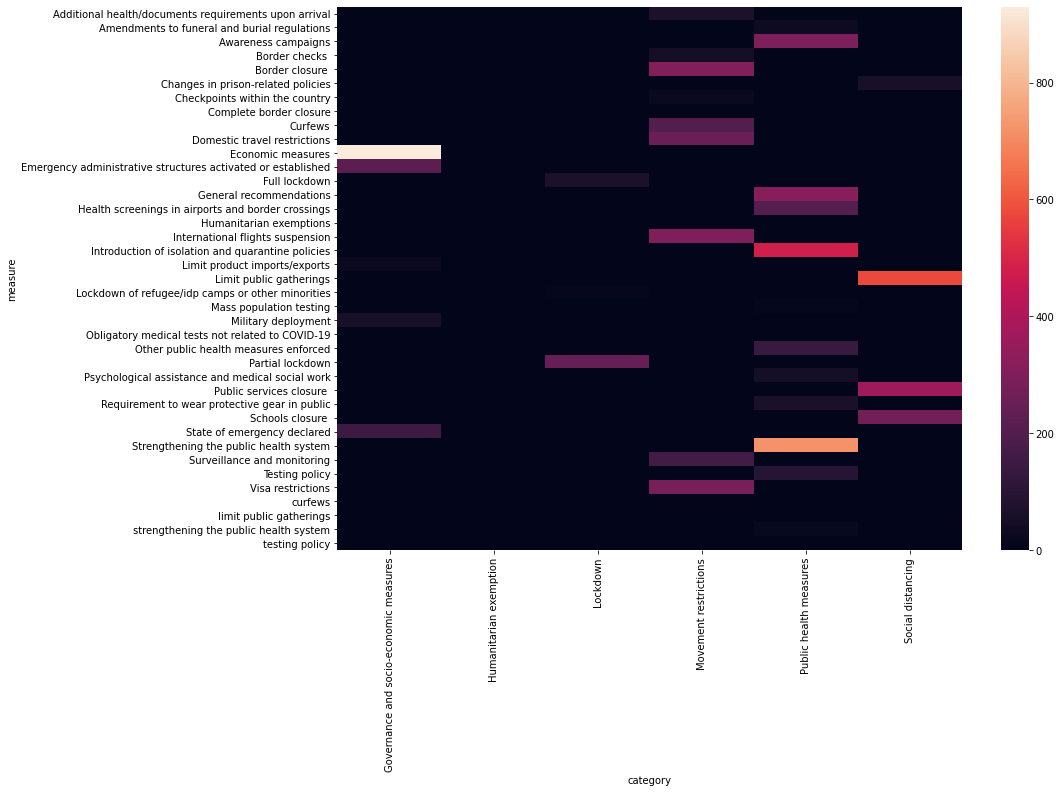

In [12]:
plt.subplots(figsize=(14, 10))
pd.crosstab(measures.measure, measures.category).pipe(sns.heatmap)


In [13]:
some_measures = (measures
                      .loc[lambda f: 
                           ~f['category'].isin(['Governance and socio-economic measures', 'Public health measures']) 
#                            & f['source_type'].eq('Government') 
#                            & f['admin_level_name'].isna()
                          ]
                 .fillna({'admin_level_name': 'Global'})
                     )


In [14]:
ecdc_nona = ecdc[['date', 'iso_code', 'location', 'new_cases']].assign(new_cases=lambda f: f['new_cases'].replace(0, np.nan)).dropna()

ts_data = (ecdc_nona
           .merge(some_measures[['iso', 'measure', 'category', 'log_type', 'admin_level_name', 'comments', 'date_implemented', 'link']], 
                     left_on=['iso_code', 'date'], right_on=['iso', 'date_implemented'], how='outer')
           .merge(isocodes[['alpha-3_code', 'alpha-2_code']], left_on='iso_code', right_on='alpha-3_code', how='outer')
           .merge(mobility_country.to_frame().query('mobility_category == "workplaces"').reset_index()
                  [['change', 'mobility_category', 'country_region_code', 'country_region', 'date']], 
                  left_on=['alpha-2_code', 'date'], right_on=['country_region_code', 'date'], how='left', indicator=True)
          )
ts_data.loc[lambda f: f['alpha-2_code'].isna()].country_region.value_counts()
ts_data.shape

(9028, 19)

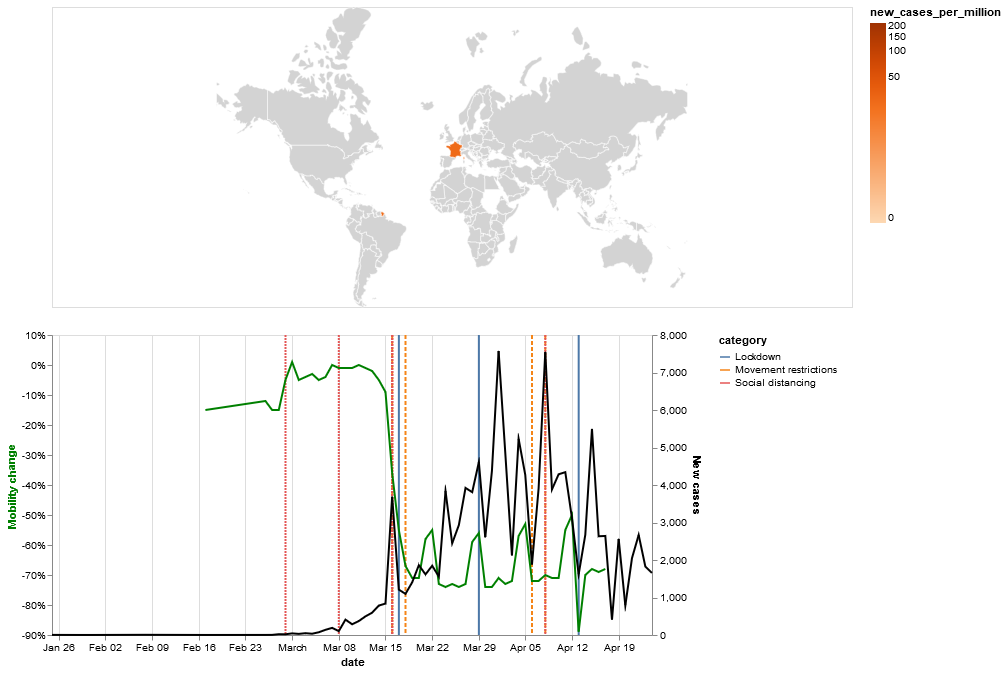

In [17]:
from vega_datasets import data
from IPython.display import display

counties = alt.topo_feature(data.world_110m.url, 'countries')

# lockdown_map_data = lockdown_countries.groupby('iso').last().reset_index()
ecdc_map_data = ecdc.groupby('iso_code').last().reset_index()[['iso_code', 
                                                    'new_cases',
                                                    'new_cases_per_million', 
                                                    'total_cases',
                                                    'total_cases_per_million',
                                                    'location']]

map_data = ecdc_map_data.merge(isocodes, left_on='iso_code', right_on='alpha-3_code', how='outer')


color_field = 'new_cases_per_million:Q'

selection_country = alt.selection_multi(fields=['location'], init=[{'location': 'France'}], empty='all')
selection_country_2 = alt.selection_multi(fields=['location'], init=[{'location': 'France'}], empty='none')
selection_country_3 = alt.selection_multi(fields=['location'], init=[{'location': 'France'}], empty='all')

selection_rule = alt.selection_single(fields=['date'], nearest=True, on='mouseover', 
#                                       clear='mouseout'
                                     )
selection_legend = alt.selection_multi(fields=['category'], bind='legend')

map_chart = (alt.Chart(counties).mark_geoshape(stroke='white', strokeWidth=0.5).encode(
    tooltip=['location:N', color_field],
    color=alt.condition(
        selection_country, 
        alt.Color(color_field, scale=alt.Scale(scheme='oranges', type='symlog', base=10), legend=alt.Legend(orient='right')),
        alt.value('lightgray')
    )
).transform_filter(
    'datum.id != 10 & datum.id != 304'
)
             .add_selection(selection_country)
             .add_selection(selection_country_2)
             .add_selection(selection_country_3)
.transform_lookup(
    lookup='id',
    from_=alt.LookupData(map_data, 'numeric_code', ['country_name', 
                                                    'new_cases',
                                                    'new_cases_per_million', 
                                                    'total_cases',
                                                    'total_cases_per_million',
                                                    'location'
                                                   ])
).properties(
    width=800,
#     height=500
))


base = (alt.Chart(ts_data).encode(x='date:T').properties(width=600))

# date_domain = alt.selection_interval(bind='scales', encodings=['x'])

lines = (base
            .mark_line(color='black')
            .encode(
                y=alt.Y('new_cases', axis=alt.Axis(title='New cases', titleColor='black')))
         .add_selection(selection_country)
         .transform_filter(selection_country)
         .transform_aggregate(
                new_cases='sum(new_cases)',
                groupby=['date'])
#          .add_selection(date_domain)
        )

mobility_chart = (base
                  .mark_line(color='green')
                  .encode(y=alt.Y('change', axis=alt.Axis(title='Mobility change', format='%', titleColor='green')), )
                  .add_selection(selection_country_3)
                  .transform_filter(selection_country_3)
                  .transform_aggregate(
                      change='mean(change)',
                      groupby=['date']
                  )
                 )

measures_chart = (base
#           .mark_point(filled=True, size=50)
#           .mark_tick(thickness=2, size=300)
                  .mark_rule(size=2)
          .transform_filter('datum.measure != null')
          .encode(
#               y='new_cases', 
              tooltip=['location', 'date:T', 'measure', 'category', 'log_type', 'admin_level_name', 'comments', 'link'], 
              href='link:N',
              strokeDash=alt.StrokeDash('category:N', legend=None),
              color=alt.condition(selection_rule | selection_legend, alt.Color('category:N', legend=alt.Legend(orient='right')), alt.value('lightgray')))
          .add_selection(selection_country_2)
          .transform_filter(selection_country_2)
                           .add_selection(selection_rule)
                  .add_selection(selection_legend)
#                   .transform_filter(selection_legend)
# .add_selection(date_domain)
#           .properties(height=100)
         )

(map_chart 
 &
 (
     measures_chart +
     (mobility_chart + lines).resolve_scale(y='independent').properties(height=300)
 ).resolve_scale(x='shared')
)

In [ ]:
measures_chart

In [ ]:
from vega_datasets import data
from IPython.display import display


input_dropdown = alt.binding_select(options=sorted(ts_data['location'].dropna().unique().tolist()))
selection_country_dropdown = alt.selection_single(fields=['location'],  bind=input_dropdown, name='Location', init={'location': 'France'}, empty='all')

selection_rule = alt.selection_single(fields=['date'], nearest=True, on='mouseover', clear='mouseout')
selection_legend = alt.selection_multi(fields=['category'], bind='legend')
selection_legend_mobility = alt.selection_multi(fields=['mobility_category'], bind='legend')
selection_legend_apple_mobility = alt.selection_multi(fields=['transportation_type'], bind='legend')

base = (alt.Chart(ts_data).encode(x='date:T').properties(width=700))#.add_selection(selection_country_dropdown)


lines = (base
            .mark_line()
            .encode(
                y=alt.Y('new_cases', axis=alt.Axis(title='New cases')),
                color=alt.value('black'))
         .transform_filter(selection_country_dropdown)
         .transform_aggregate(
                new_cases='sum(new_cases)',
                groupby=['date'])
#          .add_selection(date_domain)
        )

mobility_chart_data = (mobility_country
    .reset_index()
    .merge(ecdc
           .groupby('location', as_index=False)
           .first()
           [['location', 'iso_code']]
           .merge(isocodes[['alpha-3_code', 'alpha-2_code']], 
                  left_on='iso_code', 
                  right_on='alpha-3_code', 
                  how='outer'),
          left_on='country_region_code', right_on='alpha-2_code'))

mobility_axis = alt.Axis(title='Mobility change', format='%')

mobility_chart = (alt.Chart(mobility_chart_data)
                  .mark_line()
                  .encode(
                      x='date:T',
                      y=alt.Y('change',
                                  axis=mobility_axis), 
                          color=
                      alt.condition(selection_legend_mobility, 
                                              'mobility_category',
                                              alt.value('lightgray'))
                  )
#                   .add_selection(selection_country_dropdown_cases)
                  .transform_filter(selection_country_dropdown)
                  .add_selection(selection_legend_mobility)
#                   .transform_aggregate(
#                       change='mean(change)',
#                       groupby=['date']
#                   )
                 )

apple_mobility_chart = (
    alt.Chart(apple_mobility.assign(change=lambda f: f['change'].div(100).sub(1)))
    .mark_line()
    .encode(x='date:T', 
            y=alt.Y('change', axis=mobility_axis),
            color=alt.condition(selection_legend_apple_mobility, 
                                              'transportation_type',
                                              alt.value('lightgray'))
           )
    .transform_filter(selection_country_dropdown)
    .add_selection(selection_legend_apple_mobility)
)

measures_chart = (base
#           .mark_point(filled=True, size=50)
#           .mark_tick(thickness=2, size=300)
                  .mark_rule(size=2)
          .transform_filter('datum.measure != null')
          .encode(
#               y='new_cases', 
              tooltip=['location', 'date:T', 'measure', 'category', 'log_type', 'admin_level_name', 'comments', 'link'], 
              href='link:N',
              strokeDash=alt.StrokeDash('category:N'),
              color=alt.condition(selection_rule | selection_legend, 
                                  alt.Color('category:N'), alt.value('lightgray')))
#           .add_selection(selection_country_dropdown_measures)
          .transform_filter(selection_country_dropdown)
                           .add_selection(selection_rule)
                  .add_selection(selection_legend)
#                   .transform_filter(selection_legend)
# .add_selection(date_domain)
#           .properties(height=100)
         )
(
    measures_chart &
 (mobility_chart
#   + measures_chart
    +
    apple_mobility_chart
 )
    & 
    (
#         measures_chart 
#      + 
        lines
    )
).resolve_scale(x='shared').add_selection(selection_country_dropdown).resolve_legend(color='independent')

In [ ]:
measures

In [ ]:
mobility_country_workplaces = mobility_country.reset_index().query('mobility_category == "workplaces"')
mobility_country_workplaces